# Camelot

Best for modern text-based pdfs where the contents can be selected and copied from bluebeam. Doesn't work on older "image-based" pdfs where OCR is required. Provides excellent quality for text based tables though.

In [1]:
import camelot

In [2]:
path_to_pdf = "res/100843 - Table Only.pdf"

In [3]:
tables = camelot.read_pdf(path_to_pdf)

In [4]:
tables[0].parsing_report

{'accuracy': 100.0, 'whitespace': 92.02, 'order': 1, 'page': 1}

In [5]:
tables[0].df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,,,,,,,,,,,,EROSION CONTROL
1,,,,,,,,,,,,,,,,,,
2,,,,,,,,,,,"1,000",,,832,30000,"1,000",EACH,EROSION CONTROL
3,,,,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,,,,PAVEMENT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,,,,,,,,,,,,,,,,,,
67,,,,,,,,,,,,,,,,,,
68,,,,,,,,,,,,,,,,,,
69,,,,,,,,,,,,,,,,,,


# Tabula

Simplified user interface, java based which creates a lot of headaches when setting up, can be made to run faster by installing jpype with `pip install tablula-py[jpype]`.

> \# // TODO - Couldn't get Java environment configured correctly

In [1]:
import os

os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-22\bin\server"

In [2]:
import tabula

In [3]:
tabula.environment_info()

Python version:
    3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
Java version:
    openjdk version "1.8.0_152-release"
OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12)
OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
tabula-py version: 2.9.3
platform: Windows-10-10.0.19045-SP0
uname:
    uname_result(system='Windows', node='CLEVLDPARKS', release='10', version='10.0.19045', machine='AMD64')
linux_distribution: ('', '', '')
mac_ver: ('', ('', '', ''), '')


In [4]:
dfs2 = tabula.read_pdf("res/JUNIATA RIVER.pdf")

JVMNotFoundException: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.

# OpenCV/Tessarct

The most complicated of the methods requiring custom functions to be written for basically all aspects of the translation

In [17]:
import fitz
from PIL import Image

doc = fitz.open("res/JUNIATA RIVER.pdf")

for page in doc:
    pix = page.get_pixmap(
        matrix=fitz.Identity, dpi=None, colorspace=fitz.csRGB, clip=None, annots=True
    )
    pix.save("res/temp/samplepdfimage-%i.jpg" % page.number)  # save file

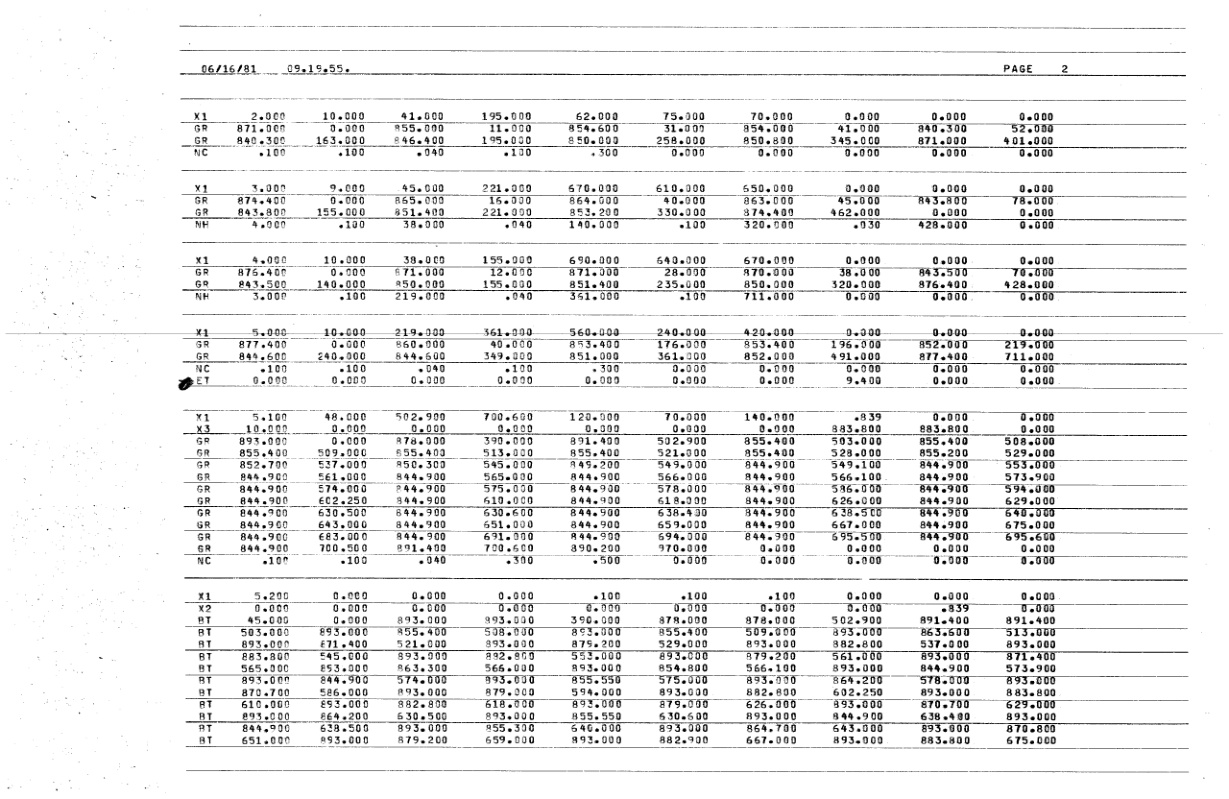

In [21]:
test_image = Image.open("res/temp/samplepdfimage-2.jpg")
test_image

In [53]:
import os
import cv2
import imutils
from matplotlib import pyplot as plt


def pre_process_image(img, save_in_file, morph_size=(8, 8)):

    # get rid of the color
    pre = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Otsu threshold
    pre = cv2.threshold(pre, 250, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # dilate the text to make it solid spot
    cpy = pre.copy()
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    cpy = cv2.dilate(~cpy, struct, anchor=(-1, -1), iterations=1)
    pre = ~cpy

    if save_in_file is not None:
        cv2.imwrite(save_in_file, pre)
    return pre

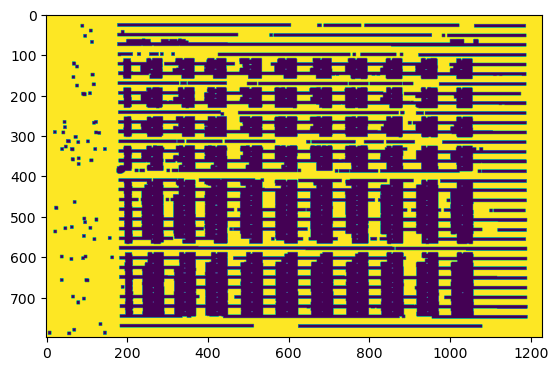

In [54]:
img = cv2.imread("res/temp/samplepdfimage-2.jpg")
pre_processed_img = pre_process_image(img, "res/temp/samplepdfimage-2-processed.jpg")

plt.imshow(pre_processed_img)

In [56]:
def find_text_boxes(pre, min_text_height_limit=6, max_text_height_limit=40):
    # Looking for the text spots contours
    # OpenCV 3
    # img, contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4
    contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Getting the texts bounding boxes based on the text size assumptions
    boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h < max_text_height_limit:
            boxes.append(box)

    return boxes

In [61]:
text_boxes = find_text_boxes(pre_processed_img)
text_boxes

[(52, 785, 11, 10),
 (141, 783, 10, 11),
 (4, 783, 10, 11),
 (65, 776, 10, 10),
 (624, 767, 458, 10),
 (182, 766, 334, 10),
 (130, 762, 10, 10),
 (973, 728, 31, 17),
 (712, 728, 32, 16),
 (800, 727, 31, 17),
 (625, 727, 32, 17),
 (538, 727, 31, 17),
 (451, 727, 33, 17),
 (293, 727, 25, 16),
 (214, 727, 26, 16),
 (75, 708, 10, 11),
 (886, 704, 32, 16),
 (800, 704, 31, 15),
 (712, 704, 32, 15),
 (625, 704, 32, 15),
 (538, 704, 32, 15),
 (293, 703, 25, 15),
 (215, 703, 25, 15),
 (89, 699, 10, 10),
 (62, 694, 10, 10),
 (973, 681, 31, 39),
 (799, 680, 32, 16),
 (711, 680, 33, 16),
 (624, 680, 33, 16),
 (538, 680, 31, 16),
 (450, 680, 34, 39),
 (371, 680, 25, 39),
 (185, 670, 10, 10),
 (973, 656, 31, 17),
 (799, 656, 31, 16),
 (711, 656, 33, 16),
 (625, 656, 31, 16),
 (538, 655, 31, 17),
 (451, 655, 32, 17),
 (372, 655, 23, 17),
 (95, 653, 13, 11),
 (34, 653, 10, 10),
 (973, 633, 31, 15),
 (799, 632, 31, 16),
 (711, 632, 33, 16),
 (624, 632, 32, 15),
 (538, 632, 31, 15),
 (450, 632, 33, 15),

In [65]:
def find_table_in_boxes(boxes, cell_threshold=10, min_columns=2):
    rows = {}
    cols = {}

    # Clustering the bounding boxes by their positions
    for box in boxes:
        (x, y, w, h) = box
        col_key = x // cell_threshold
        row_key = y // cell_threshold
        cols[row_key] = [box] if col_key not in cols else cols[col_key] + [box]
        rows[row_key] = [box] if row_key not in rows else rows[row_key] + [box]

    # Filtering out the clusters having less than 2 cols
    table_cells = list(filter(lambda r: len(r) >= min_columns, rows.values()))
    # Sorting the row cells by x coord
    table_cells = [list(sorted(tb)) for tb in table_cells]
    # Sorting rows by the y coord
    table_cells = list(sorted(table_cells, key=lambda r: r[0][1]))

    return table_cells

In [66]:
cells = find_table_in_boxes(text_boxes)
cells

[[(85, 24, 10, 10),
  (176, 22, 432, 10),
  (671, 23, 13, 10),
  (687, 23, 95, 10),
  (788, 23, 237, 10),
  (1060, 24, 130, 10)],
 [(106, 36, 10, 10), (176, 39, 301, 17)],
 [(92, 49, 10, 10),
  (553, 47, 10, 10),
  (563, 47, 394, 10),
  (980, 48, 10, 10),
  (993, 48, 198, 10)],
 [(109, 64, 10, 10), (176, 60, 1015, 21)],
 [(177, 94, 39, 11),
  (225, 94, 11, 10),
  (255, 94, 25, 10),
  (282, 94, 10, 10),
  (310, 94, 10, 10),
  (425, 95, 330, 10),
  (759, 95, 10, 10),
  (778, 95, 91, 10),
  (876, 95, 10, 10),
  (922, 96, 269, 10)],
 [(211, 127, 23, 16),
  (368, 127, 27, 16),
  (622, 128, 40, 15),
  (708, 128, 33, 15),
  (797, 128, 38, 15),
  (883, 128, 33, 15)],
 [(113, 169, 11, 10),
  (177, 166, 154, 10),
  (332, 166, 18, 10),
  (350, 166, 99, 10),
  (497, 167, 27, 10),
  (525, 167, 224, 10),
  (749, 167, 51, 10),
  (801, 167, 83, 10),
  (883, 167, 28, 10),
  (973, 168, 218, 10)],
 [(87, 192, 14, 12),
  (104, 191, 10, 10),
  (211, 199, 24, 15),
  (289, 199, 39, 16)],
 [(448, 200, 39, 15)

In [67]:
def build_lines(table_cells):
    if table_cells is None or len(table_cells) <= 0:
        return [], []

    max_last_col_width_row = max(table_cells, key=lambda b: b[-1][2])
    max_x = max_last_col_width_row[-1][0] + max_last_col_width_row[-1][2]

    max_last_row_height_box = max(table_cells[-1], key=lambda b: b[3])
    max_y = max_last_row_height_box[1] + max_last_row_height_box[3]

    hor_lines = []
    ver_lines = []

    for box in table_cells:
        x = box[0][0]
        y = box[0][1]
        hor_lines.append((x, y, max_x, y))

    for box in table_cells[0]:
        x = box[0]
        y = box[1]
        ver_lines.append((x, y, x, max_y))

    (x, y, w, h) = table_cells[0][-1]
    ver_lines.append((max_x, y, max_x, max_y))
    (x, y, w, h) = table_cells[0][0]
    hor_lines.append((x, max_y, max_x, max_y))

    return hor_lines, ver_lines

In [69]:
hor_lines, ver_lines = build_lines(cells)
hor_lines

[(85, 24, 1191, 24),
 (106, 36, 1191, 36),
 (92, 49, 1191, 49),
 (109, 64, 1191, 64),
 (177, 94, 1191, 94),
 (211, 127, 1191, 127),
 (113, 169, 1191, 169),
 (87, 192, 1191, 192),
 (448, 200, 1191, 200),
 (178, 238, 1191, 238),
 (916, 240, 1191, 240),
 (41, 262, 1191, 262),
 (42, 275, 1191, 275),
 (17, 287, 1191, 287),
 (75, 312, 1191, 312),
 (35, 329, 1191, 329),
 (212, 343, 1191, 343),
 (61, 354, 1191, 354),
 (76, 366, 1191, 366),
 (219, 382, 1191, 382),
 (212, 415, 1191, 415),
 (370, 438, 1191, 438),
 (296, 454, 1191, 454),
 (214, 487, 1191, 487),
 (90, 501, 1191, 501),
 (92, 510, 1191, 510),
 (43, 525, 1191, 525),
 (18, 533, 1191, 533),
 (89, 544, 1191, 544),
 (115, 552, 1191, 552),
 (180, 573, 1191, 573),
 (34, 595, 1191, 595),
 (58, 601, 1191, 601),
 (214, 631, 1191, 631),
 (34, 653, 1191, 653),
 (371, 680, 1191, 680),
 (62, 694, 1191, 694),
 (75, 708, 1191, 708),
 (214, 727, 1191, 727),
 (130, 762, 1191, 762),
 (4, 783, 1191, 783),
 (85, 794, 1191, 794)]

In [71]:
ver_lines

[(85, 24, 85, 794),
 (176, 22, 176, 794),
 (671, 23, 671, 794),
 (687, 23, 687, 794),
 (788, 23, 788, 794),
 (1060, 24, 1060, 794),
 (1191, 24, 1191, 794)]

In [76]:
# Visuzalize the result
vis = img.copy()

for line in hor_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

for line in ver_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

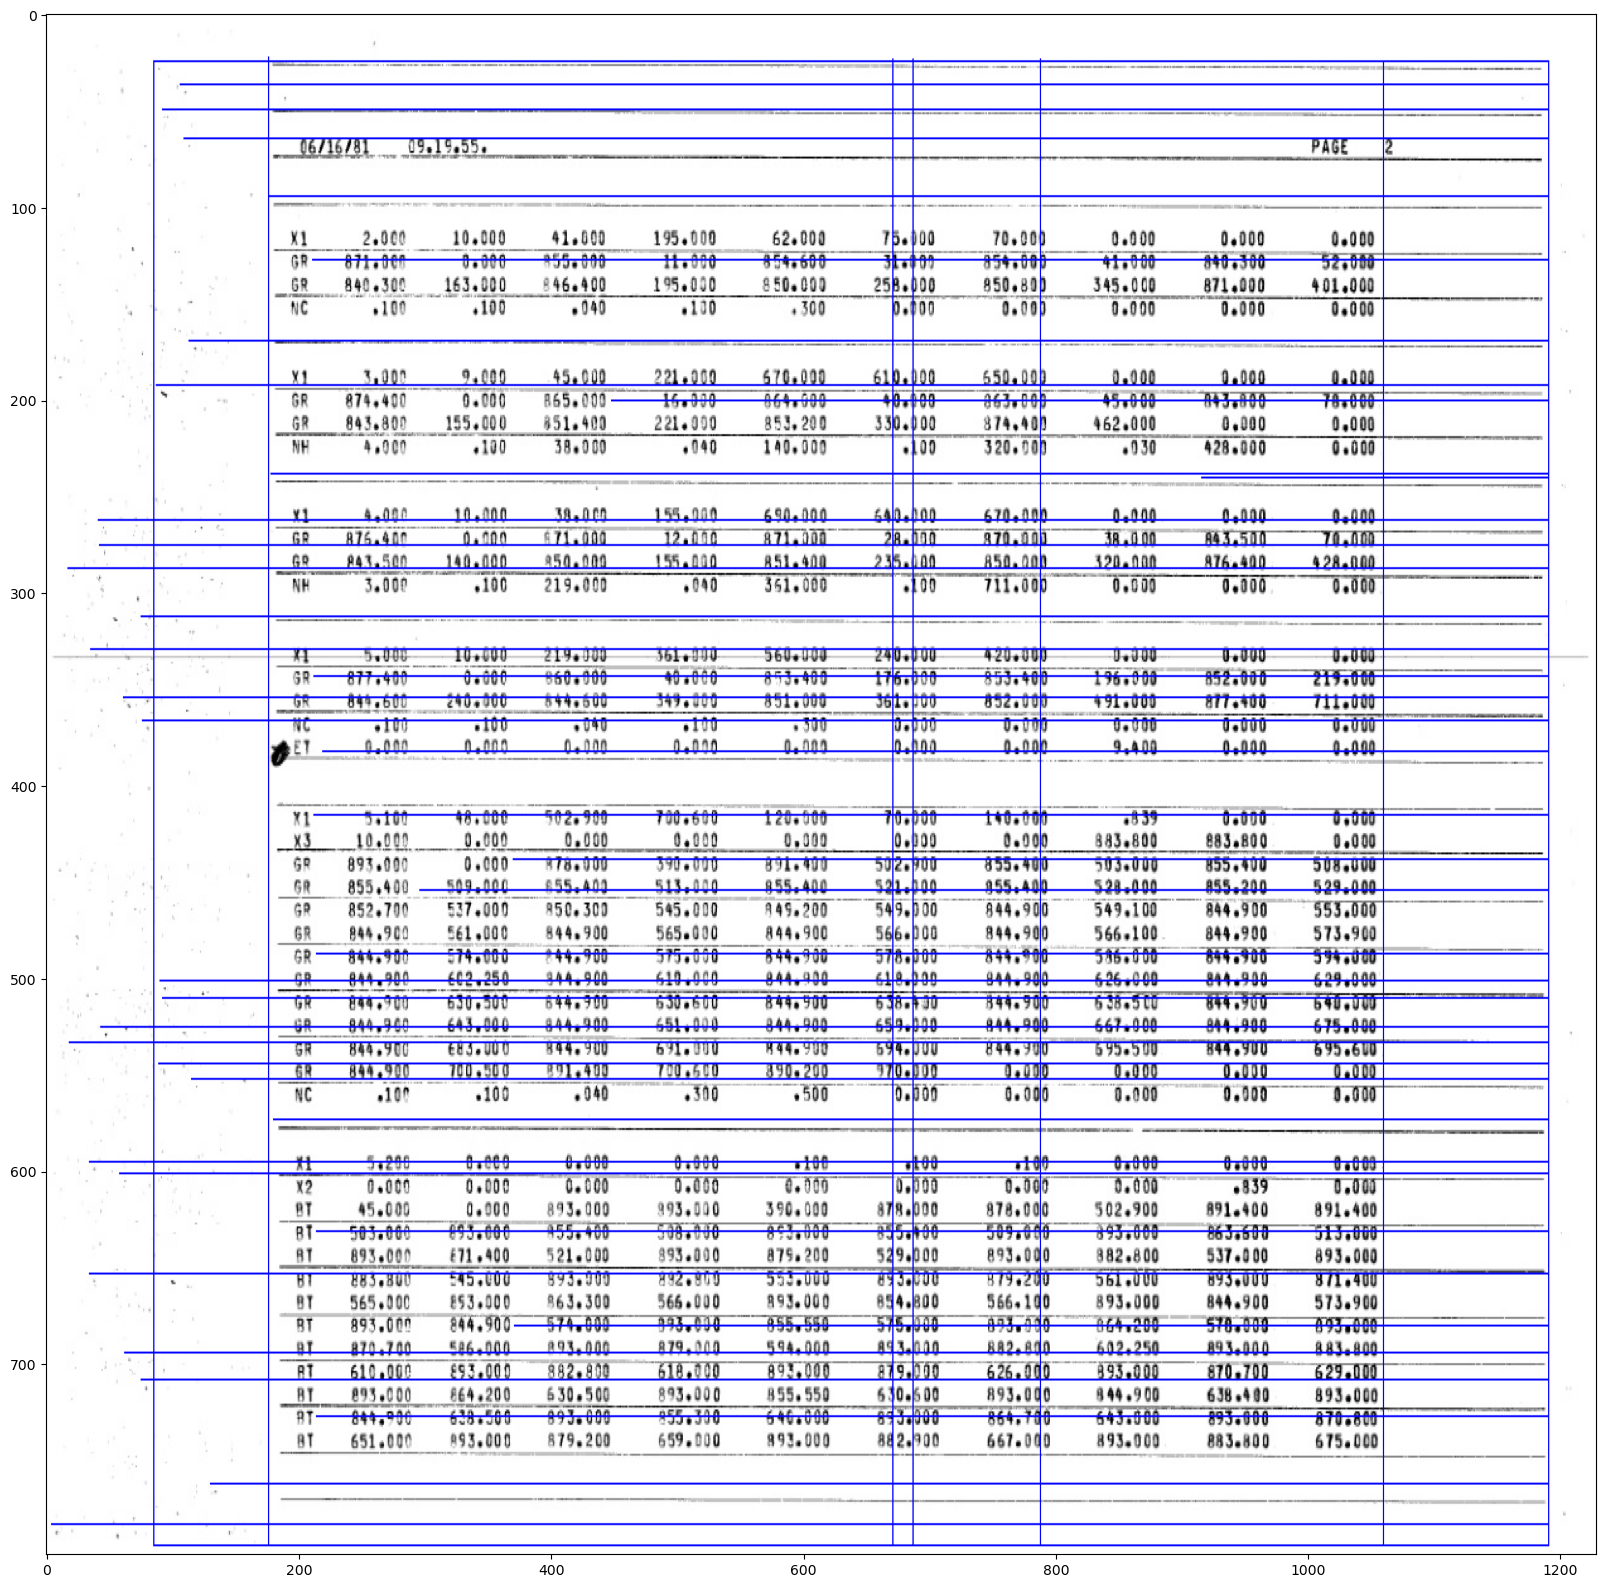

In [80]:
plt.figure(figsize=(20, 20))
plt.imshow(vis, aspect="auto")

In [27]:
class Line:
    def __init__(self, startx, starty, endx, endy):
        self.startx = startx
        self.starty = starty
        self.endx = endx
        self.endy = endy

    def __str__(self):
        return "Line:{},{},{},{}".format(self.startx, self.starty, self.endx, self.endy)

    def lenx(self):
        return abs(self.startx - self.endx)

    def leny(self):
        return abs(self.starty - self.endy)

    def toArray(self):
        return [self.startx, self.starty, self.endx, self.endy]


def reDrawLine(img, aleft, aright, same_len=True):
    w, h = img.shape[0], img.shape[1]
    for r in range(w - 1):
        pixel_white = 0
        start = 0
        end = 0
        for c in range(h - 1):
            if img[r, c] == 255:
                pixel_white += 1
            if img[r, c] == 0 and img[r, c + 1] == 255:
                start = c
            if img[r, c] == 255 and img[r, c + 1] == 0:
                end = c
        if pixel_white > 20:
            if same_len:
                img[r, aleft:aright] = 255
            else:
                img[r, start:end] = 255
    return img


def findMinMaxRow(v_img):
    aleft, aright = 0, 0
    list_col = []
    w, h = v_img.shape[0], v_img.shape[1]
    for r in range(w - 1):
        pixel_white = 0
        for c in range(h - 1):
            if v_img[r, c] == 255:
                pixel_white += 1
        if pixel_white > 20:
            list_col.append(r)
    aleft, aright = min(list_col), max(list_col)
    return aleft, aright


def getLines(img):
    lines = []
    w, h = img.shape[0], img.shape[1]
    for r in range(w - 1):
        pixel_white = 0
        startx, starty, endx, endy = 0, 0, 0, 0
        for c in range(h - 1):
            if img[r, c] == 0 and img[r, c + 1] == 255:
                startx = c
                starty = r
            if img[r, c] == 255 and img[r, c + 1] == 0:
                endx = c
                endy = r
            if img[r, c] == 255:
                pixel_white += 1
        if pixel_white > 20:
            lines.append(Line(startx, starty, endx, endy))
            # print(Line(startx,starty,endx,endy).toArray())
    return lines


def getTable(src_img, y_start=0, min_w=10, min_h=10):
    if y_start != 0:
        src_img = src_img[y_start:, :]
    if len(src_img.shape) == 2:
        gray_img = src_img
    elif len(src_img.shape) == 3:
        gray_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)

    thresh_img = cv2.adaptiveThreshold(
        ~gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, -3
    )
    h_img = thresh_img.copy()
    v_img = thresh_img.copy()
    scale = 15

    h_size = int(h_img.shape[1] / scale)
    h_structure = cv2.getStructuringElement(cv2.MORPH_RECT, (h_size, 1))

    h_erode_img = cv2.erode(h_img, h_structure, 1)
    h_dilate_img = cv2.dilate(h_erode_img, h_structure, 1)

    v_size = int(v_img.shape[0] / scale)
    v_structure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_size))
    v_erode_img = cv2.erode(v_img, v_structure, 1)
    v_dilate_img = cv2.dilate(v_erode_img, v_structure, 1)

    aleft, aright = findMinMaxRow(v_dilate_img.T)
    aleft2, aright2 = findMinMaxRow(h_dilate_img)

    h_dilate_img = reDrawLine(h_dilate_img, aleft, aright, True)
    # v_dilate_img = reDrawLine(v_dilate_img.T, aleft, aright, False).T
    # cv2.imshow('h_dilate_img',h_dilate_img)
    # cv2.imshow('h_dilate_img',v_dilate_img)
    # cv2.waitKey()
    # list_hlines = getLines(h_dilate_img)
    # list_vlines = getLines(v_dilate_img.T)
    # print(len(list_hlines))
    # print(len(list_vlines))
    # for i,_ in list_hlines:
    #    for j,_ in list_hlines
    # exit()
    # v_dilate_img = reDrawLine(v_dilate_img.T, aleft2, aright2, True).T
    v_dilate_img.T[aleft, aleft2:aright2] = 255
    v_dilate_img.T[aright, aleft2:aright2] = 255

    edges = cv2.Canny(h_dilate_img, 50, 150, apertureSize=3)
    # print(len(edges))

    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    # print(len(lines))
    # cv2.waitKey()
    mask_img = h_dilate_img + v_dilate_img
    joints_img = cv2.bitwise_and(h_dilate_img, v_dilate_img)
    # mask_img = 255 - mask_img
    # mask_img = unsharp_mask(mask_img)
    convolution_kernel = np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]])

    # mask_img = cv2.filter2D(mask_img, -1, convolution_kernel)
    # mask_img = 255- mask_img
    # cv2.imshow('mask', mask_img)
    # cv2.imshow('joints_img', joints_img)
    # cv2.waitKey()
    # cv2.imshow('join', joints_img)
    # cv2.waitKey()
    # fig, ax = plt.subplots(2,2)
    # fig.suptitle("table detect")
    # ax[0,0].imshow(h_dilate_img)
    # ax[0,1].imshow(v_dilate_img)
    # ax[1,0].imshow(mask_img)
    # ax[1,1].imshow(joints_img)
    # plt.show()cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    (contours, boundingBoxes) = cont.sort_contours(contours, method="left-to-right")
    (contours, boundingBoxes) = cont.sort_contours(contours, method="top-to-bottom")

    table = findTable([cv2.boundingRect(x) for x in contours])

    # for r in table:
    #     for c in r:

    #         cv2.rectangle(src_img,(c[0], c[1]),(c[0] + c[2], c[1] + c[3]),(0, 0, 255), 1)
    #         cv2.putText(src_img, , (c[0] + c[2]//2,c[1] + c[3]//2), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 2)
    # for c in contours:
    #     x, y, w, h = cv2.boundingRect(c)
    #     if (w >= min_w and h >= min_h):
    #         #count += 1
    #         if count != 0:
    #             cv2.rectangle(src_img,(x, y),(x + w, y + h),(0, 0, 255), 1)
    #             list_cells.append([x,y,w,h])
    #             cv2.putText(src_img, str(count), (x+w//2,y+h//2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
    #         count += 1
    # cv2.waitKey()
    # cv2.imwrite('a.jpg', src_img)
    return table  # mask_img, joints_img


def getTextOfBox(img):
    return pytesseract.image_to_string(
        img, config="-l vie+en --oem 1 --psm 7"
    ).strip()  # .lower()


def putTextUTF8(img, text, point, fsize=10):
    fontpath = "Roboto-Regular.ttf"
    font = ImageFont.truetype(fontpath, fsize)
    img_pil = Image.fromarray(img)
    draw = ImageDraw.Draw(img_pil)
    draw.text(point, text, font=font, fill=((0, 0, 0)))
    img = np.array(img_pil)
    return img


def getTableValue(table, img, img_ocr, fsize):
    # img_ocr = img.copy()
    # img_ocr = cv2.cvtColor(img_ocr,cv2.COLOR_BGR2GRAY)
    data = []
    header = []
    for i, row in enumerate(table):
        data_row = []
        for cell in row:
            crop = img_ocr[
                cell[1] + 2 : cell[1] + cell[3] - 2, cell[0] + 2 : cell[0] + cell[2] - 2
            ]
            # cv2.imwrite(str(i)+".png",crop)
            cell_text = getTextOfBox(crop)
            if i == 0:
                header.append(cell_text)
                cv2.rectangle(
                    img,
                    (cell[0], cell[1]),
                    (cell[0] + cell[2], cell[1] + cell[3]),
                    (0, 255, 0),
                    -1,
                )
            else:
                cv2.rectangle(
                    img,
                    (cell[0], cell[1]),
                    (cell[0] + cell[2], cell[1] + cell[3]),
                    (0, 255, 255),
                    -1,
                )
                data_row.append(cell_text)
            img = putTextUTF8(img, cell_text, (cell[0], cell[1]), fsize)
        if i == 0:
            data.append(header)
        else:
            data.append(data_row)
    return data, img


img = cv2.imread("input.jpg")
img2 = img.copy()

table = getTable(img)
data, img = getTableValue(table, img, img2, 10)
cv2.imwrite("recog.jpg", img)